<a href="https://colab.research.google.com/github/Shivp55/DAML/blob/main/DAML2_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub
from google.colab import drive
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Downloading dataset
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")
dataset_path = path + '/Vegetable Images'

100%|██████████| 534M/534M [00:18<00:00, 30.6MB/s]

Extracting files...


In [4]:
# Saving dataset to Drive
drive_dataset_path = "/content/drive/MyDrive/vegetable_image_dataset"
if os.path.exists(drive_dataset_path):
    shutil.rmtree(drive_dataset_path)
shutil.copytree(dataset_path, drive_dataset_path)
print(f'Dataset saved to {drive_dataset_path}')


Dataset saved to /content/drive/MyDrive/vegetable_image_dataset


In [12]:
# Initializing Parameters
image_size = (64, 64)
batch_size = 32
num_classes = 15
epochs = 30

# Defining paths
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'validation')
test_path = os.path.join(dataset_path, 'test')

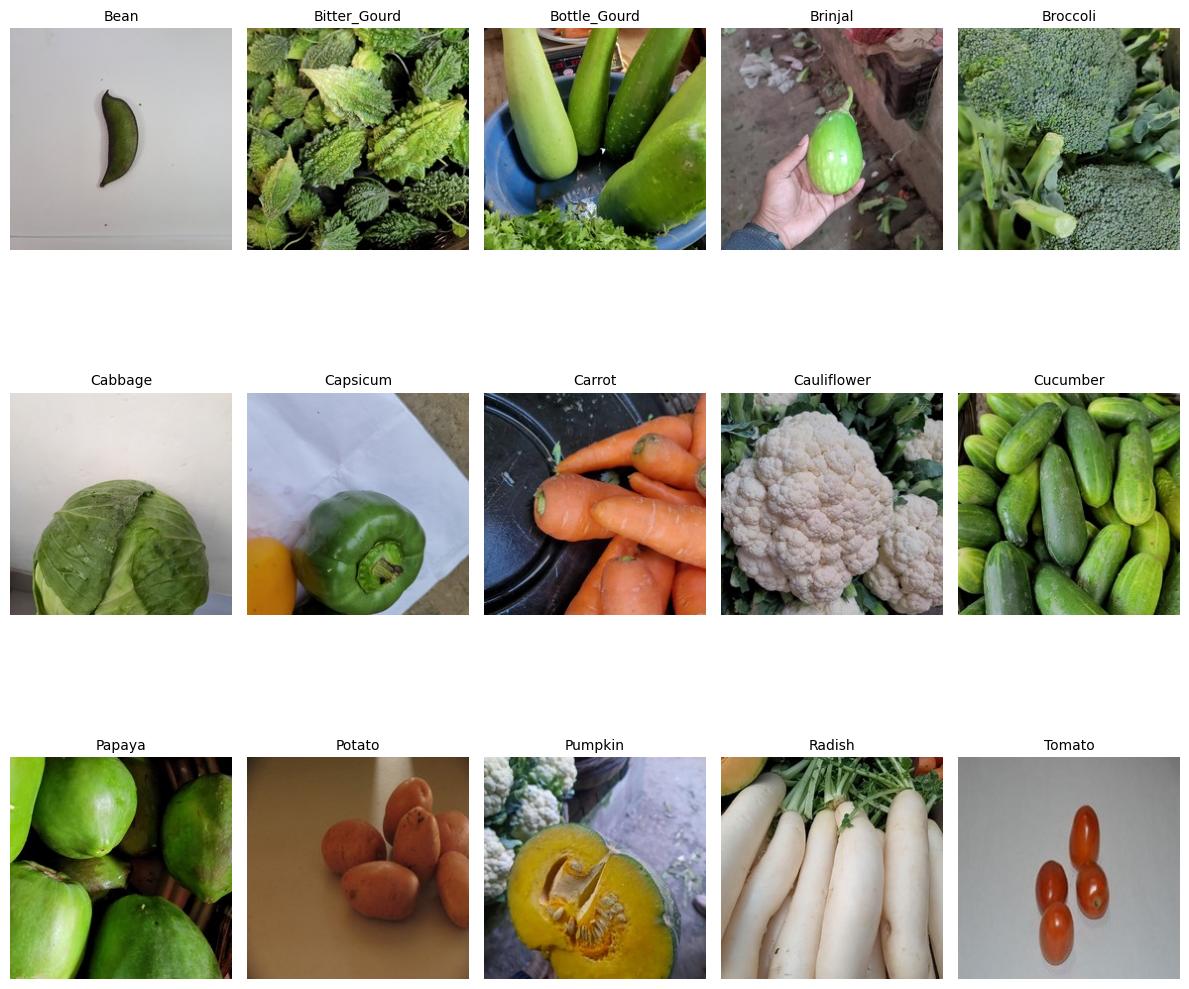

In [ ]:
# Function to show images in an n*3 grid
def show_images_grid(dataset, rows=5, cols=3):
    # Creating grid layout
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    # Flattening axes for easier indexing
    axes = axes.flatten()

    class_to_idx = dataset.class_to_idx
    # Reverse mapping
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    class_shown = set()
    img_index = 0

    for img, label in dataset:
        class_name = idx_to_class[label]
        # Picking first unique image for each class
        if class_name not in class_shown:
            # Convert tensor image
            axes[img_index].imshow(img.permute(1, 2, 0))
            axes[img_index].set_title(class_name, fontsize=10)
            axes[img_index].axis("off")
            class_shown.add(class_name)
            img_index += 1

        # Stop when all classes are shown
        if len(class_shown) == len(class_to_idx):
            break

    plt.tight_layout()
    plt.show()

# Loading dataset with transformations
train_dataset = datasets.ImageFolder(root=train_path, transform=transforms.ToTensor())

# Displaying images in a 5x3 grid
show_images_grid(train_dataset, rows=3, cols=5)


In [13]:
# Data Augmentation
def get_augmented_dataloaders(train_path, val_path, test_path, batch_size):
    train_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=val_path, transform=val_test_transform)
    test_dataset = datasets.ImageFolder(root=test_path, transform=val_test_transform)

    class_names = train_dataset.classes
    print(f'Classes: {class_names}')

    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, class_names

In [14]:
# Loading data
train_loader, val_loader, test_loader, class_names = get_augmented_dataloaders(
    train_path, val_path, test_path, batch_size)

Classes: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [15]:
# Basic CNN Architecture
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, model_name, epochs=30, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    best_val_loss = float('inf')
    counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, {model_name} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 100)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Saving best model
            torch.save(model.state_dict(), f'/content/drive/MyDrive/vegetable_image_dataset/{model_name}_best.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Saving final model
    torch.save(model.state_dict(), f'/content/drive/MyDrive/vegetable_image_dataset/{model_name}_final.pth')
    return history


In [17]:
# Initializing the BasicCNN model
cnn_model = BasicCNN(num_classes=num_classes)
model_name='BasicCNN'
# Training the model
history= train_model(cnn_model, train_loader, val_loader, model_name='BasicCNN', epochs=epochs)

Epoch 1/30, BasicCNN | Train Loss: 1.9336, Train Acc: 35.99% | Val Loss: 1.5725, Val Acc: 49.77%
----------------------------------------------------------------------------------------------------
Epoch 2/30, BasicCNN | Train Loss: 1.6017, Train Acc: 47.07% | Val Loss: 1.3489, Val Acc: 54.03%
----------------------------------------------------------------------------------------------------
Epoch 3/30, BasicCNN | Train Loss: 1.4562, Train Acc: 52.03% | Val Loss: 1.0819, Val Acc: 63.87%
----------------------------------------------------------------------------------------------------
Epoch 4/30, BasicCNN | Train Loss: 1.3507, Train Acc: 55.57% | Val Loss: 1.1227, Val Acc: 61.43%
----------------------------------------------------------------------------------------------------
Epoch 5/30, BasicCNN | Train Loss: 1.2665, Train Acc: 58.35% | Val Loss: 1.1171, Val Acc: 63.50%
----------------------------------------------------------------------------------------------------
Epoch 6/30

In [18]:
# Evaluate function
def evaluate_model(model, test_loader, model_name):
    model.eval()
    test_loss = 0
    correct, total = 0, 0
    criterion = nn.CrossEntropyLoss()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total

    print(f'{model_name} Test Results:')
    print(f'Test Loss:: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    return test_loss, test_acc, all_preds, all_labels

In [19]:
test_loss, test_acc, preds, labels = evaluate_model(cnn_model, test_loader, model_name)

BasicCNN Test Results:
Test Loss: 0.4320, Test Accuracy: 86.17%


In [20]:
results = {}
results[model_name] = {
        'history': history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'preds': preds,
        'labels': labels
    }
history = results[model_name]['history']

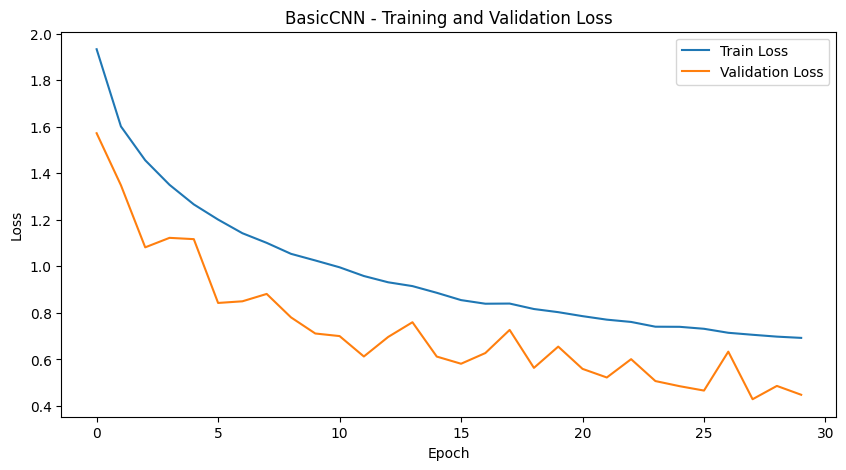

In [21]:
# Training and validation loss Plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{model_name} - Training and Validation Loss')
plt.legend()
plt.show()

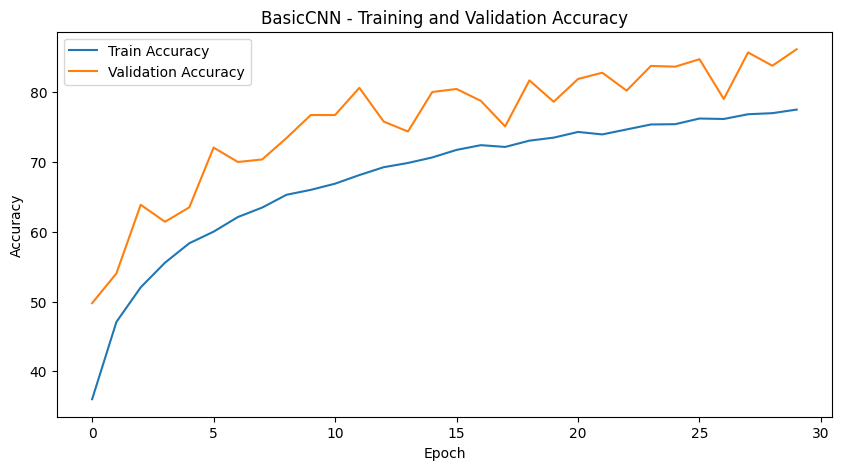

In [22]:
# Training and validation accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{model_name} - Training and Validation Accuracy')
plt.legend()
plt.show()


In [23]:
# Loading the trained model
model_path = '/content/drive/MyDrive/vegetable_image_dataset/BasicCNN_final.pth'
model = BasicCNN(num_classes=15)
model.load_state_dict(torch.load(model_path))
model.eval()

BasicCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [24]:
# Defining image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
# Function to perform prediction
def predict_vegetable(image_path, class_names):
    try:
        img = Image.open(image_path)
        img = transform(img)
        img = img.unsqueeze(0)  # Adding batch dimension

        with torch.no_grad():
            output = model(img)
            _, predicted_idx = torch.max(output, 1)
            predicted_class = class_names[predicted_idx.item()]

        # Visualization
        plt.imshow(Image.open(image_path))
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

        return predicted_class
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

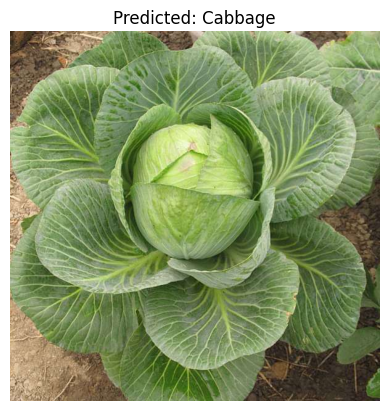

In [26]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/R.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

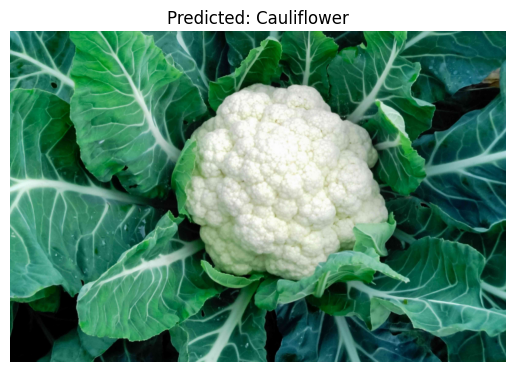

In [27]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/clflwr.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

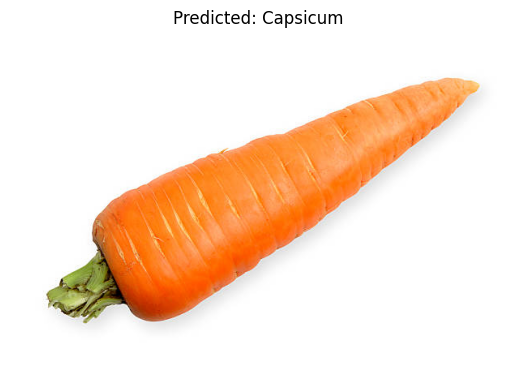

In [28]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/c1.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

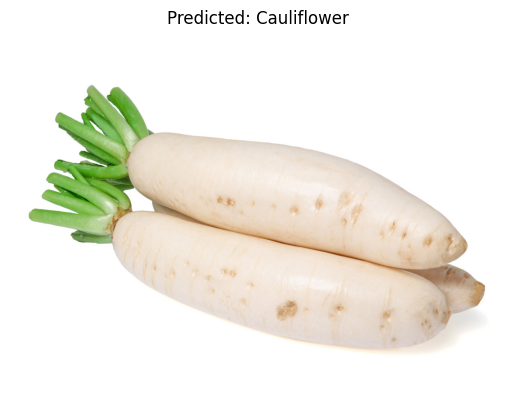

In [29]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/radish.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

In [31]:
# Improved Base CNN
class ImprovedBaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedBaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Adding additional conv layer
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Adjusted the input size
        self.fc2 = nn.Linear(256, 128)  # Adding another fully connected layer
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
# Initializing the ImprovedBaseCNN model
cnn_model = ImprovedBaseCNN(num_classes=num_classes)
model_name='ImprovedBaseCNN'
# Training the model
history= train_model(cnn_model, train_loader, val_loader, model_name, epochs=20)

Epoch 1/20, ImprovedBaseCNN | Train Loss: 1.9518, Train Acc: 35.51% | Val Loss: 1.2940, Val Acc: 58.37%
----------------------------------------------------------------------------------------------------
Epoch 2/20, ImprovedBaseCNN | Train Loss: 1.5048, Train Acc: 49.64% | Val Loss: 1.0749, Val Acc: 65.30%
----------------------------------------------------------------------------------------------------
Epoch 3/20, ImprovedBaseCNN | Train Loss: 1.3205, Train Acc: 55.97% | Val Loss: 0.8866, Val Acc: 72.63%
----------------------------------------------------------------------------------------------------
Epoch 4/20, ImprovedBaseCNN | Train Loss: 1.1888, Train Acc: 60.68% | Val Loss: 0.8392, Val Acc: 71.87%
----------------------------------------------------------------------------------------------------
Epoch 5/20, ImprovedBaseCNN | Train Loss: 1.0823, Train Acc: 63.85% | Val Loss: 0.7312, Val Acc: 76.20%
----------------------------------------------------------------------------

In [33]:
test_loss, test_acc, preds, labels = evaluate_model(cnn_model, test_loader, model_name)

ImprovedBaseCNN Test Results:
Test Loss: 0.2124, Test Accuracy: 94.43%


In [34]:
results = {}
results[model_name] = {
        'history': history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'preds': preds,
        'labels': labels
}
history = results[model_name]['history']

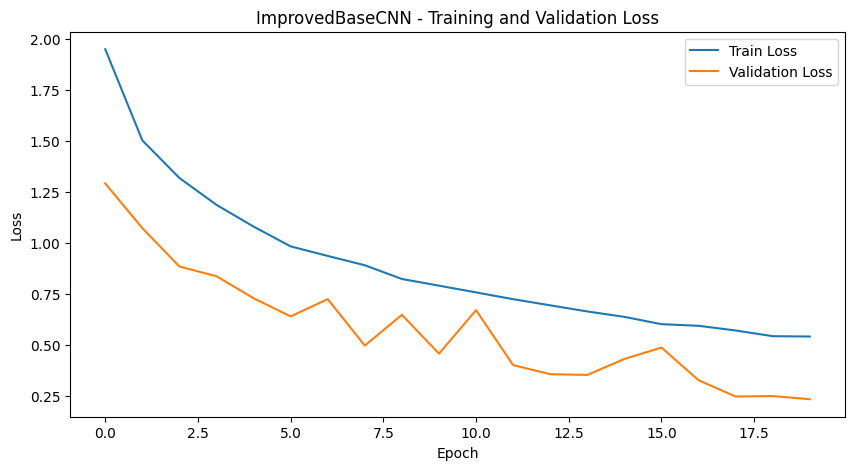

In [35]:
# Training and validation loss plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{model_name} - Training and Validation Loss')
plt.legend()
plt.show()

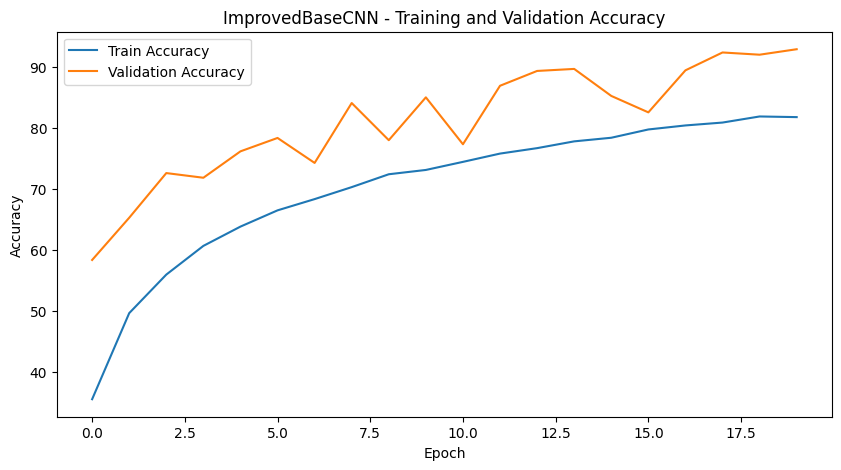

In [36]:
# Training and validation accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{model_name} - Training and Validation Accuracy')
plt.legend()
plt.show()

In [37]:
# Loading the trained model
model_path = '/content/drive/MyDrive/vegetable_image_dataset/ImprovedBaseCNN_final.pth'
model = ImprovedBaseCNN(num_classes=15)
model.load_state_dict(torch.load(model_path))
model.eval()

ImprovedBaseCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

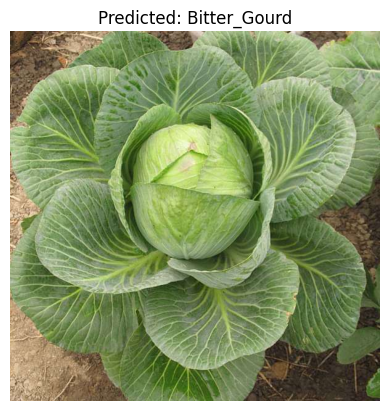

In [38]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/R.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

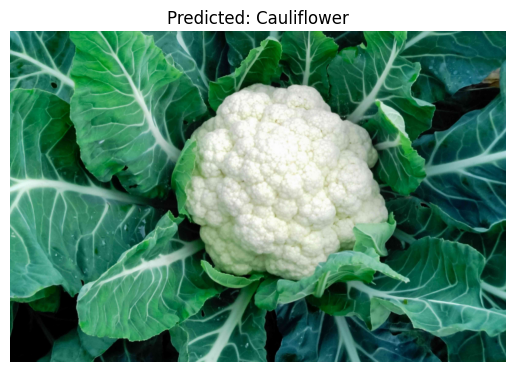

In [39]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/clflwr.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

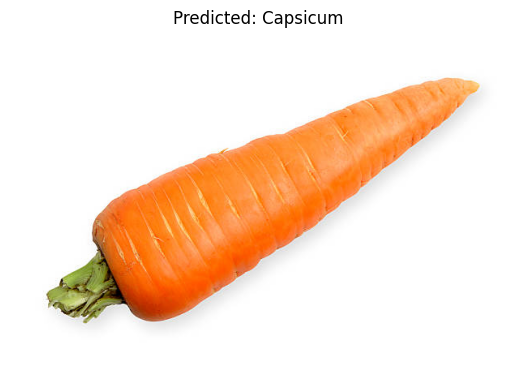

In [40]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/c1.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

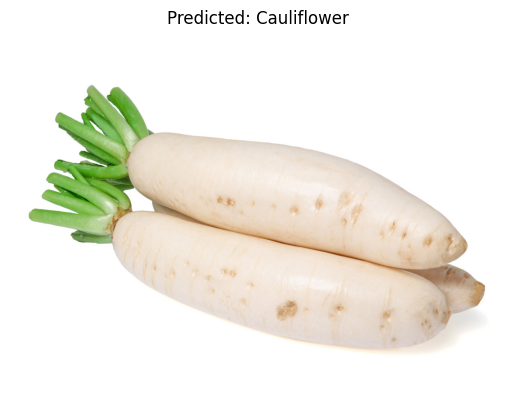

In [41]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/radish.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

In [43]:
# Deeper CNN
class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [45]:
# Initializing the DeeperCNN model
cnn_model = DeeperCNN(num_classes=num_classes)
model_name='DeeperCNN'
# Training the model
history= train_model(cnn_model, train_loader, val_loader, model_name, epochs=10)

Epoch 1/10, DeeperCNN | Train Loss: 2.1616, Train Acc: 27.85% | Val Loss: 1.4956, Val Acc: 49.30%
----------------------------------------------------------------------------------------------------
Epoch 2/10, DeeperCNN | Train Loss: 1.7051, Train Acc: 43.32% | Val Loss: 1.2696, Val Acc: 57.33%
----------------------------------------------------------------------------------------------------
Epoch 3/10, DeeperCNN | Train Loss: 1.4871, Train Acc: 50.85% | Val Loss: 1.0654, Val Acc: 65.77%
----------------------------------------------------------------------------------------------------
Epoch 4/10, DeeperCNN | Train Loss: 1.3288, Train Acc: 55.91% | Val Loss: 0.9670, Val Acc: 67.97%
----------------------------------------------------------------------------------------------------
Epoch 5/10, DeeperCNN | Train Loss: 1.2184, Train Acc: 59.75% | Val Loss: 0.8836, Val Acc: 70.77%
----------------------------------------------------------------------------------------------------
Epoch

In [46]:
test_loss, test_acc, preds, labels = evaluate_model(cnn_model, test_loader, model_name)

DeeperCNN Test Results:
Test Loss: 0.4893, Test Accuracy: 83.03%


In [47]:
results = {}
results[model_name] = {
        'history': history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'preds': preds,
        'labels': labels
}
history = results[model_name]['history']

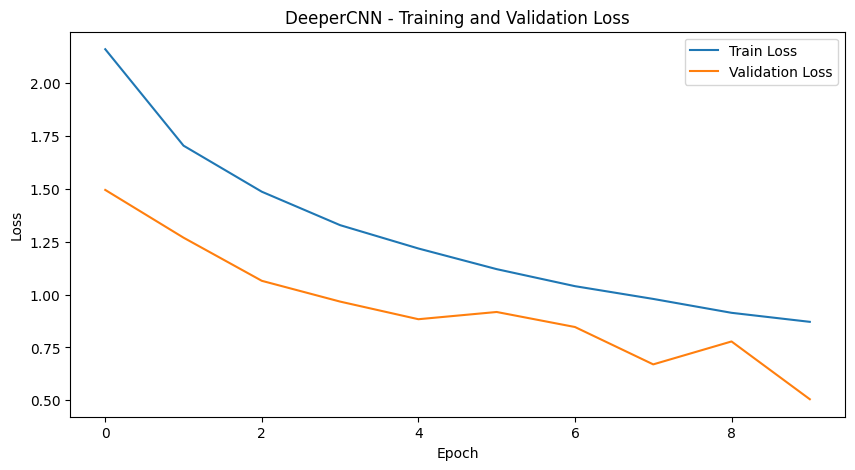

In [48]:
# Training and validation loss Plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{model_name} - Training and Validation Loss')
plt.legend()
plt.show()

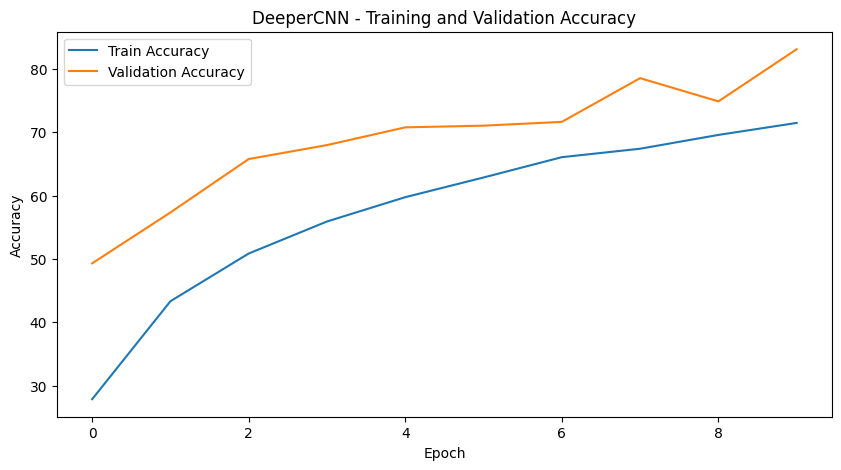

In [49]:
# Training and validation accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{model_name} - Training and Validation Accuracy')
plt.legend()
plt.show()

In [50]:
# Loading the trained model
model_path = '/content/drive/MyDrive/vegetable_image_dataset/DeeperCNN_final.pth'
model = DeeperCNN(num_classes=15)
model.load_state_dict(torch.load(model_path))
model.eval()

DeeperCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, inplace

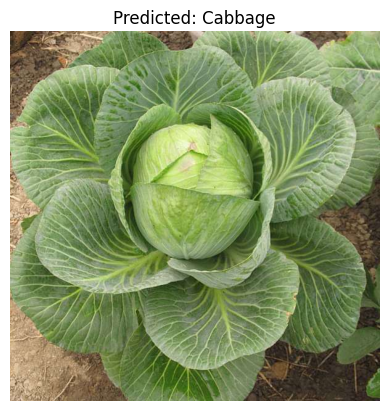

In [51]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/R.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

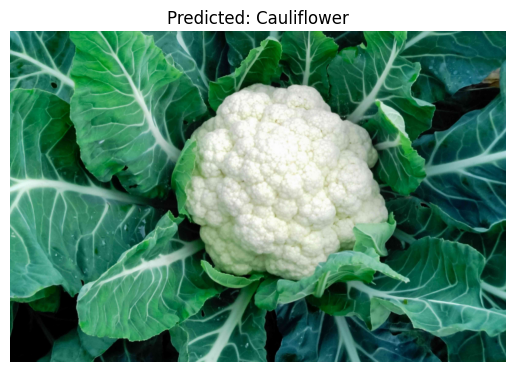

In [52]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/clflwr.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

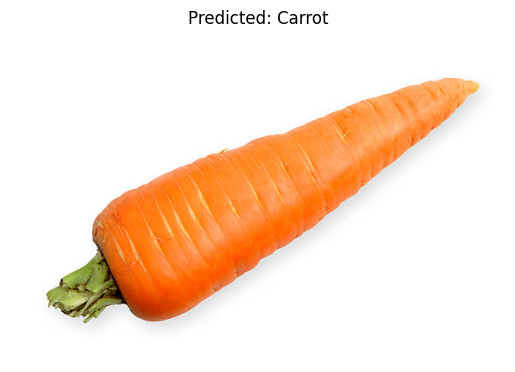

In [53]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/c1.jpeg'
predicted_class = predict_vegetable(image_path, class_names)

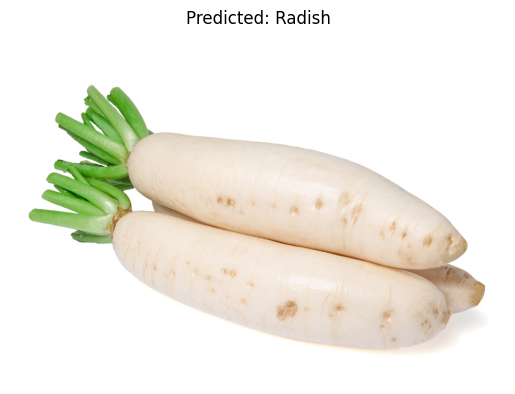

In [54]:
# Prediction on Unknown Image
image_path = '/content/drive/MyDrive/vegetable_image_dataset/unknown_imgs/radish.jpeg'
predicted_class = predict_vegetable(image_path, class_names)